This is the weekly project for week three. We have the following description:

This week you'll be implementing your own block matching algorithm for stereo depth reconstruction. Thus you are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries. You can find all necessary image-files in the attached zip-file.

It is recommended you use the following three intermediate steps before going directly to a full implementation:

### **Intermediate step 1:**

Implement a function that takes two equal size images and calculates the sum of absolute differences. The two equal-sized images are nose_left.png (used as the template) and nose_right.png.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data

img_left = cv2.imread("nose_left.png")
img_right = cv2.imread("nose_right.png")

def sad(img1, img2):
    
    return np.sum(np.abs(img1 - img2))

sad_value = sad(img_left, img_right)
print("SAD:", sad_value)

SAD: 22971


### **Intermediate step 2:**
Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

In [2]:
img_nose1 = cv2.imread("nose1.png")
img_nose2 = cv2.imread("nose2.png")
img_nose3 = cv2.imread("nose3.png")

print("SAD between nose_left.png and nose1.png: ", sad(img_left, img_nose1))
print("SAD between nose_left.png and nose2.png: ", sad(img_left, img_nose2))
print("SAD between nose_left.png and nose3.png: ", sad(img_left, img_nose3))

SAD between nose_left.png and nose1.png:  13653
SAD between nose_left.png and nose2.png:  16839
SAD between nose_left.png and nose3.png:  4470


### **Intermediate step 3:**
Since these images are rectified, we can approximately assume that a pixel found in row x in the left image also lives in row x in the right image. nose_span.png contains the entire row containing the nose of the sculpture. The height of the span is 7 - the same height as your template. Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.

In [3]:
img_span = cv2.imread("nose_span.png")

gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_span = cv2.cvtColor(img_span, cv2.COLOR_BGR2GRAY)

height = 7

def find_nose_location(img, span, height):
    
    width = img.shape[1]
    span_height, span_width = span.shape
    
    # Compute the starting row and extract the row block from the span image
    row_start = (span_height - height) // 2
    span_row_block = span[row_start:row_start + height, :]
    
    min_sad = float('inf')
    nose_col = -1
    
    # Iterate over possible columns in the span image where the template can fit
    for col in range(span_width - width + 1):
        # Extract the current block from the span row
        span_block = span_row_block[:, col:col + width]
       
        # Compute SAD between the template and the current block
        sad_value = sad(img, span_block)
        
        # Update minimum SAD and column index if necessary
        if sad_value < min_sad:
            min_sad = sad_value
            nose_col = col
    
    
    return (nose_col+3)


nose_col = find_nose_location(gray_left, gray_span, height)
print("Nose is located in column): ", nose_col)




Nose is located in column):  160


### **Full template matching implementation (Challenge):**
Write a template matching function that iteratively takes a 7x7 subpart (numpy calls this slicing) of tsukuba_left.png and uses your function from step 3 to apply it to the corresponding row in tsukuba_right.png and stores the lowest/best matching disparity value for that template. Continue until all possible templates for a row has been used before moving down to the next row in the image.

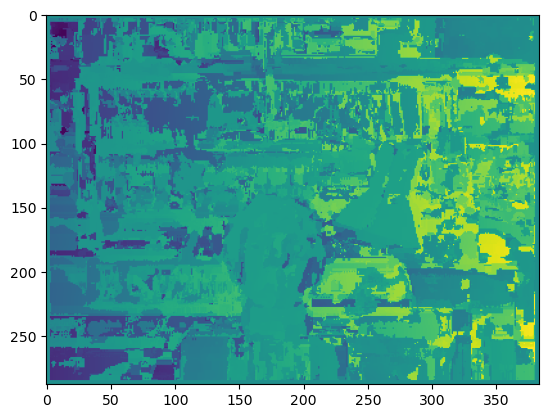

In [5]:
img_left2 = cv2.imread("tsukuba_left.png")
img_right2 = cv2.imread("tsukuba_right.png")

gray_left2 = cv2.cvtColor(img_left2, cv2.COLOR_BGR2GRAY)
gray_right2 = cv2.cvtColor(img_right2, cv2.COLOR_BGR2GRAY)

# f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
# ax_left.imshow(img_left2)
# ax_right.imshow(img_right2)

def compute_disparity_map(tsukuba_left, tsukuba_right, window_size=7):
    # Get the shape of the left and right images
    height, width = tsukuba_left.shape
    disparity_map = np.zeros((height, width), dtype=np.int32)

    half_window = window_size // 2

    # Iterate over each row of the images
    for row in range(half_window, height - half_window):
        for col in range(half_window, width - half_window):
            # Extract the 7x7 template from the left image
            template = tsukuba_left[row - half_window: row + half_window + 1, col - half_window: col + half_window + 1]
            
            # Use find_nose_location to find the best matching column in the right image for this row
            best_match_col = find_nose_location(template, tsukuba_right[row - half_window: row + half_window + 1, :], window_size)
            
            # Compute the disparity as the difference between column positions in the left and right images
            disparity = col - best_match_col
            disparity_map[row, col] = disparity
    
    return disparity_map


# Compute disparity map
disparity_map = compute_disparity_map(gray_left2, gray_right2)

# Visualize disparity map
plt.imshow(disparity_map)


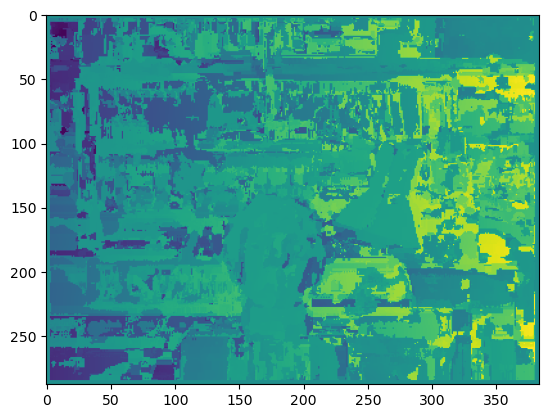